# Trainable circuits

We are fulled with feature map configurations, trainable circuits and definitions we can leverage to surpass what we obtained initially in our experiments. Let's go for it!

In [1]:
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()

X_idx = np.where(iris.target > 0)
X = iris.data[X_idx]
Y = iris.target[X_idx] -1

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

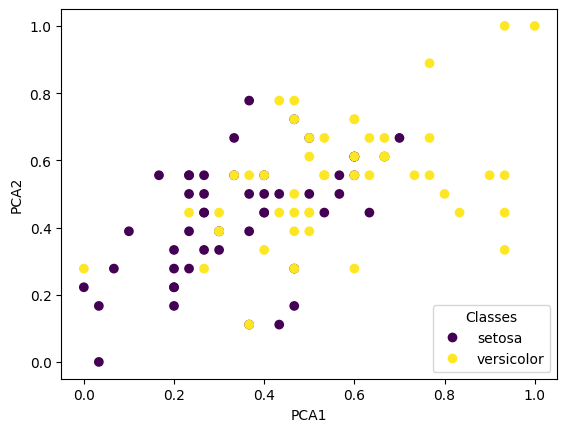

In [3]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=Y)
ax.set(xlabel="PCA1", ylabel="PCA2")
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names[0:len(Y)], loc="lower right", title="Classes"
)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.33, random_state=42)

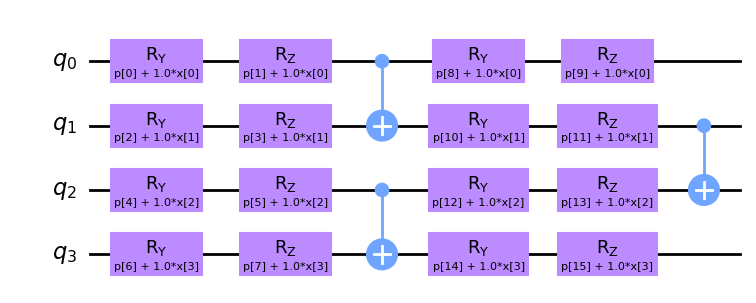

In [5]:
from squlearn.encoding_circuit import YZ_CX_EncodingCircuit
from squlearn.kernel import FidelityKernel
from squlearn.util import Executor

features = X_train.shape[1]

enc_circ = YZ_CX_EncodingCircuit(features, num_features=features, num_layers=2, c=1.0)
q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("statevector_simulator"), parameter_seed=0
)
enc_circ.draw('mpl', style='clifford')

In [6]:
from squlearn.kernel import QSVC

qsvc = QSVC(quantum_kernel=q_kernel, probability=True)
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
     decision_function_shape='ovr', max_iter=-1, probability=True,
     quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x298efced0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

Prodict_proba provides a membership probability to each of the classes. Thus, we can evaluate how well the discriminator works on specific samples if we like.

In [7]:
Z = qsvc.predict_proba(X_test)
Z[0]

array([0.43964232, 0.56035768])

In [8]:
import numpy as np

label = []
for elem in Z:
    label += [np.argmax(elem)]

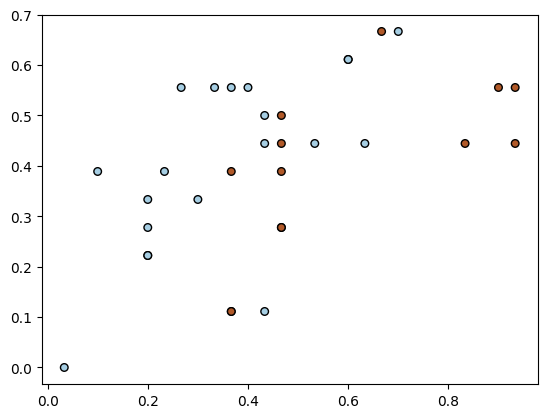

In [9]:
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=label, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.92      0.79      0.85        14

    accuracy                           0.88        33
   macro avg       0.89      0.87      0.87        33
weighted avg       0.88      0.88      0.88        33



Well, not that good. Let's try with other feature maps.

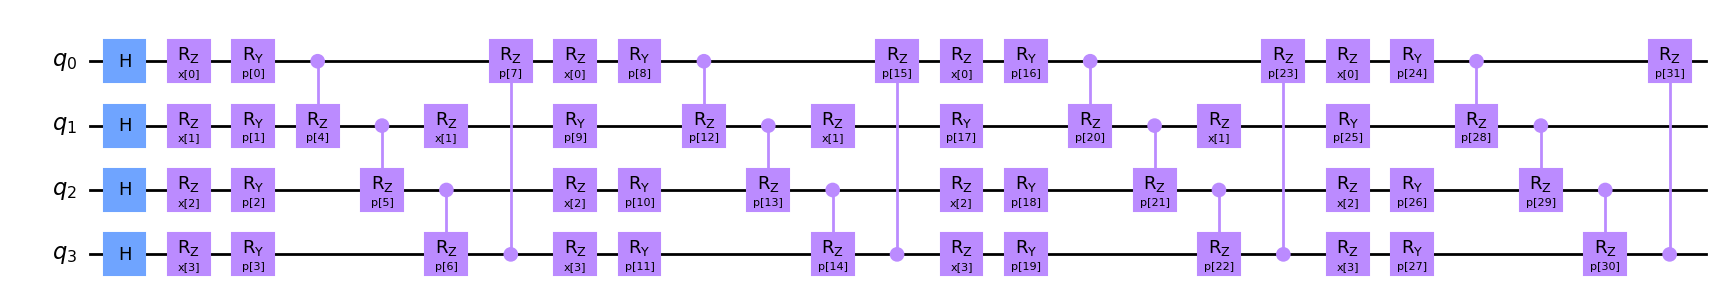

In [11]:
from squlearn.encoding_circuit import HubregtsenEncodingCircuit

enc_circ = HubregtsenEncodingCircuit(num_qubits=features, num_features=features, num_layers=4)
enc_circ.draw('mpl', style='clifford')

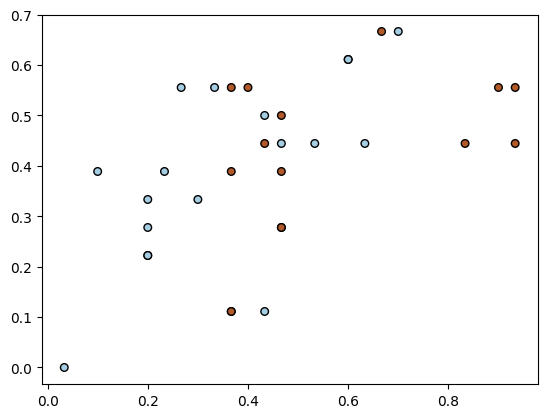

In [12]:
q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("statevector_simulator"), parameter_seed=0
)
qsvc = QSVC(quantum_kernel=q_kernel, probability=True)
qsvc.fit(X_train, y_train)

label = []
for elem in qsvc.predict_proba(X_test):
    label += [np.argmax(elem)]
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=label, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))

In [13]:
print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.93      0.93      0.93        14

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



Well, not bad but we already had that with a simple Z feature map that does no even contain entanglement.